[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/dbsn-import/blob/main/notebooks/townhalls_dbsn.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/dbsn-import/blob/main/notebooks/townhalls_dbsn.ipynb)

# Finding missing town halls in Italy

## Step 1: State Of The Art analysis

### Configuration

In [2]:
search_area_id = 3600365331 # Italia
#search_area_id = 3600042611 # Emilia-Romagna
#search_area_id = 3600040218 # Campania
# ID calculated with https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_element_id

In [3]:
province_json_file_path = f"./provinces_{search_area_id}.4326.geojson"
municipality_json_file_path = f"./municipalities_{search_area_id}.4326.geojson"
townhall_json_file_path = f"./townhalls_{search_area_id}.4326.geojson"
without_townhall_json_file_path = f"./without_townhall_{search_area_id}.4326.geojson"
dbsn_json_file_path = f"./municipi.geojson"
dbsn_conflict_file_path = f"./dbsn_conflicts_{search_area_id}.4326.geojson"
dbsn_missing_file_path = f"./dbsn_missing_{search_area_id}.4326.geojson"
untagged_json_file_path = f"./untagged_{search_area_id}.4326.geojson"
untagged_missing_json_file_path = f"./untagged_missing_{search_area_id}.4326.geojson"

### Setup

In [4]:
%pip install geopandas contextily pyproj rtree shapely mapclassify

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pandas import merge
from geopandas import GeoDataFrame, read_file, points_from_xy
from shapely.geometry import GeometryCollection, shape, Point, MultiPolygon, LineString
from shapely.ops import polygonize
from urllib.request import urlopen, urlretrieve
from urllib.error import HTTPError
from urllib.parse import quote_plus
from os.path import exists
import contextily as cx
import json
from numpy import array
from os import system

### Download municipalities and existing town halls from Overpass

In [6]:
PROVINCE_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="6"]["ISO3166-2"!="FR-74"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [7]:
MUNICIPALITY_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="8"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [8]:
TOWNHALL_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
nwr["amenity"="townhall"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [9]:
def fetchOverpassGeoDataFrame(overpass_query, geometry_transform=shape):
    url = "https://overpass-api.de/api/interpreter?data="+quote_plus(overpass_query)
    try:
        with urlopen(url) as response:
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            json_content = data.decode(encoding)
        if "Query timed out" in json_content:
            raise Exception("Query timed out")
        #print(json_content)
        json_object = json.loads(json_content)
        #print(json_object['elements'][0] if json_object['elements'] else "No elments")
        elements = [{
            "id": element["id"],
            "osm_id": element["tags"]["_osm_id"],
            "osm_type": element["tags"]["_osm_type"],
            "osm_url": 'https://www.openstreetmap.org/'+element["tags"]["_osm_type"]+'/'+element["tags"]["_osm_id"],
            "name": element["tags"]["name"] if "name" in element["tags"] else None,
            "geometry": geometry_transform(element['geometry'])
        } for element in json_object['elements']]
        #print(elements[0])
        # OSM uses WGS 84: https://wiki.openstreetmap.org/wiki/Converting_to_WGS84
        crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
        gdf = GeoDataFrame(elements, crs=crs)
    except HTTPError as err:
        print("Failed downloading data from Overpass, retry later")
        raise err
    except json.JSONDecodeError as err:
        print("Failed interpreting JSON data from Overpass")
        raise err
    return gdf

In [10]:
def readOrFetchOverpassGeoDataFrame(file_path, overpass_query, geometry_transform=shape):
    if exists(file_path):
        gdf = read_file(file_path, driver='GeoJSON')
    else:
        gdf = fetchOverpassGeoDataFrame(overpass_query, geometry_transform)
        gdf.to_file(file_path, driver='GeoJSON')
    return gdf

In [11]:
# Convert Overpass geometries into MultiPolygons - https://stackoverflow.com/a/72677231/2347196
convert_geom_to_multipolygon = lambda x: MultiPolygon(polygonize(shape(x)))

In [12]:
province_gdf = readOrFetchOverpassGeoDataFrame(province_json_file_path, PROVINCE_OVERPASS_QUERY, convert_geom_to_multipolygon)
province_gdf.count()

id          109
osm_id      109
osm_type    109
osm_url     109
name        109
geometry    109
dtype: int64

In [13]:
province_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39151,relation,https://www.openstreetmap.org/relation/39151,Agrigento,"MULTIPOLYGON (((13.98219 37.19312, 13.98220 37..."
1,2,39979,relation,https://www.openstreetmap.org/relation/39979,Nuoro,"MULTIPOLYGON (((9.62535 40.25649, 9.62514 40.2..."
2,3,40021,relation,https://www.openstreetmap.org/relation/40021,Aristanis/Oristano,"MULTIPOLYGON (((8.38245 40.33860, 8.38324 40.3..."
3,4,276369,relation,https://www.openstreetmap.org/relation/276369,Cagliari,"MULTIPOLYGON (((9.16386 39.83254, 9.16450 39.8..."
4,5,12998776,relation,https://www.openstreetmap.org/relation/12998776,Sulcis Iglesiente,"MULTIPOLYGON (((8.37422 39.02318, 8.37403 39.0..."


In [14]:
municipality_gdf = readOrFetchOverpassGeoDataFrame(municipality_json_file_path, MUNICIPALITY_OVERPASS_QUERY, convert_geom_to_multipolygon)
municipality_gdf.count()

id          7903
osm_id      7903
osm_type    7903
osm_url     7903
name        7903
geometry    7903
dtype: int64

In [15]:
municipality_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39150,relation,https://www.openstreetmap.org/relation/39150,Lampedusa e Linosa,"MULTIPOLYGON (((12.87805 35.85517, 12.87809 35..."
1,2,39777,relation,https://www.openstreetmap.org/relation/39777,Santu Antiogu/Sant'Antioco,"MULTIPOLYGON (((8.38404 39.00591, 8.38379 39.0..."
2,3,39809,relation,https://www.openstreetmap.org/relation/39809,Câdesédda/Calasetta,"MULTIPOLYGON (((8.37490 39.10915, 8.37532 39.1..."
3,4,39853,relation,https://www.openstreetmap.org/relation/39853,Igrèsias/Iglesias,"MULTIPOLYGON (((8.43347 39.30784, 8.43347 39.3..."
4,5,39915,relation,https://www.openstreetmap.org/relation/39915,Bugerru/Buggerru,"MULTIPOLYGON (((8.41075 39.44130, 8.41059 39.4..."


In [16]:
townhall_gdf = readOrFetchOverpassGeoDataFrame(townhall_json_file_path, TOWNHALL_OVERPASS_QUERY)
townhall_gdf.count()

id          7216
osm_id      7216
osm_type    7216
osm_url     7216
name        5637
geometry    7216
dtype: int64

In [17]:
townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,4492704609,node,https://www.openstreetmap.org/node/4492704609,Comune di Carloforte,POINT (8.30562 39.14578)
1,2,2440099045,node,https://www.openstreetmap.org/node/2440099045,None,POINT (8.37907 39.20365)
2,3,1853454108,node,https://www.openstreetmap.org/node/1853454108,Comune di Teulada,POINT (8.77381 38.96790)
3,4,5358907076,node,https://www.openstreetmap.org/node/5358907076,Comune di Sant'Antioco,POINT (8.45543 39.06645)
4,5,2126087185,node,https://www.openstreetmap.org/node/2126087185,Comune di San Giovanni Suergiu,POINT (8.52207 39.11028)


In [18]:
from matplotlib import pyplot as plt
def show_map(geo_df:GeoDataFrame, background_gdf:GeoDataFrame=None, color_column:str=None, cmap:str=None):
    df_wm = geo_df.to_crs(epsg=3857)
    figsize=(20,10)
    fig,ax = plt.subplots(1, 1, figsize=figsize)
    legend = False
    
    if background_gdf is not None:
        background_df_wm = background_gdf.to_crs(epsg=3857)
        ax = background_df_wm.plot(ax=ax, figsize=figsize, alpha=0.3, edgecolor='k')
    
    if color_column is not None:
        legend = True
    
    ax = df_wm.plot(ax=ax, figsize=figsize, edgecolor='k', column=color_column, cmap=cmap, legend=legend)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

Map of municipalities available on OSM:

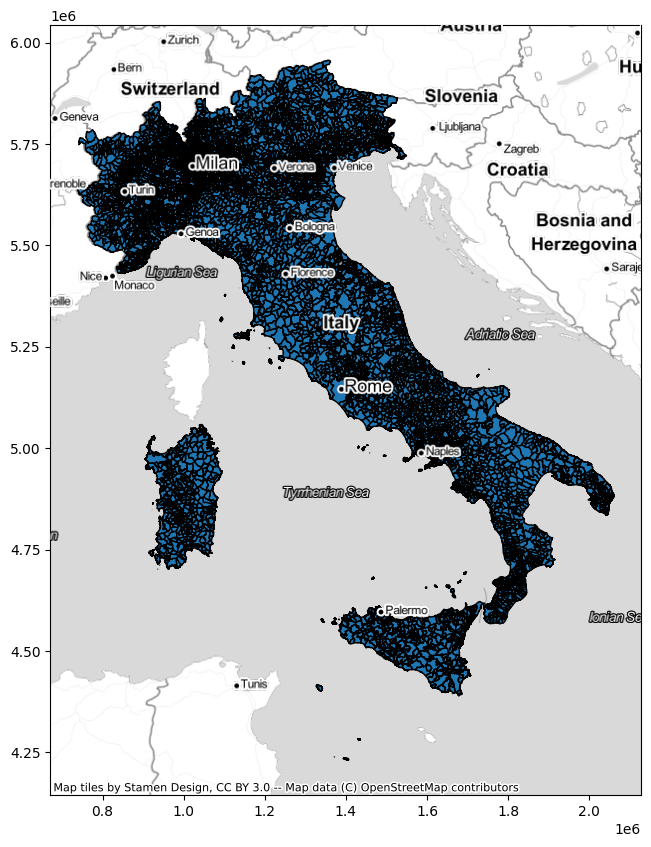

In [19]:
show_map(municipality_gdf)

Map of town halls available on OSM:

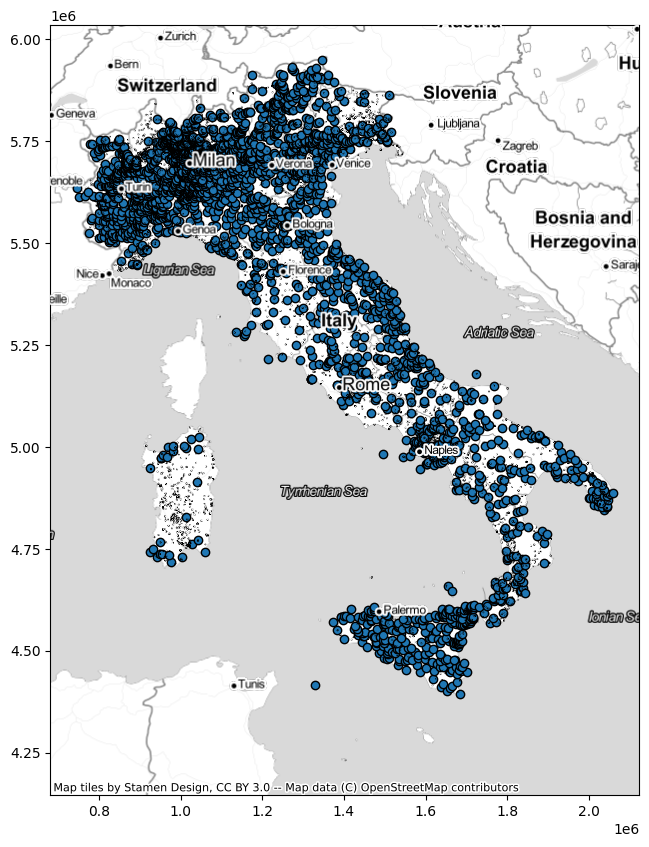

In [20]:
show_map(townhall_gdf)
#show_map(townhall_gdf, municipality_gdf)
#municipality_gdf.explore()
#townhall_gdf.explore()

### Find municipalities without town halls

In [21]:
with_townhall_gdf = townhall_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
with_townhall_gdf.count()

id_hall          7222
osm_id_hall      7222
osm_type_hall    7222
osm_url_hall     7222
name_hall        5642
geometry         7222
index_town       7222
id_town          7222
osm_id_town      7222
osm_type_town    7222
osm_url_town     7222
name_town        7222
dtype: int64

In [22]:
without_townhall_gdf = municipality_gdf[ # Anti-join
        ~municipality_gdf["id"].isin(with_townhall_gdf["id_town"])
    ]
without_townhall_gdf.to_file(without_townhall_json_file_path, driver="GeoJSON")
without_townhall_gdf.count()

id          1314
osm_id      1314
osm_type    1314
osm_url     1314
name        1314
geometry    1314
dtype: int64

In [23]:
without_townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
27,28,39855,relation,https://www.openstreetmap.org/relation/39855,Bidda Matzràxia/Villamassargia,"MULTIPOLYGON (((8.73100 39.28096, 8.73147 39.2..."
44,45,39803,relation,https://www.openstreetmap.org/relation/39803,Sa Baronia/Villaperuccio,"MULTIPOLYGON (((8.61680 39.12812, 8.61717 39.1..."
185,186,12338682,relation,https://www.openstreetmap.org/relation/12338682,Misiliscemi,"MULTIPOLYGON (((12.49852 37.96577, 12.50396 37..."
426,427,40827,relation,https://www.openstreetmap.org/relation/40827,Caragnani/Calangianus,"MULTIPOLYGON (((9.30121 40.84693, 9.30056 40.8..."
453,454,40950,relation,https://www.openstreetmap.org/relation/40950,Sant'Antoni di Gaddura/Sant'Antonio di Gallura,"MULTIPOLYGON (((9.31750 40.92267, 9.31720 40.9..."


Map of municipalities without town hall:

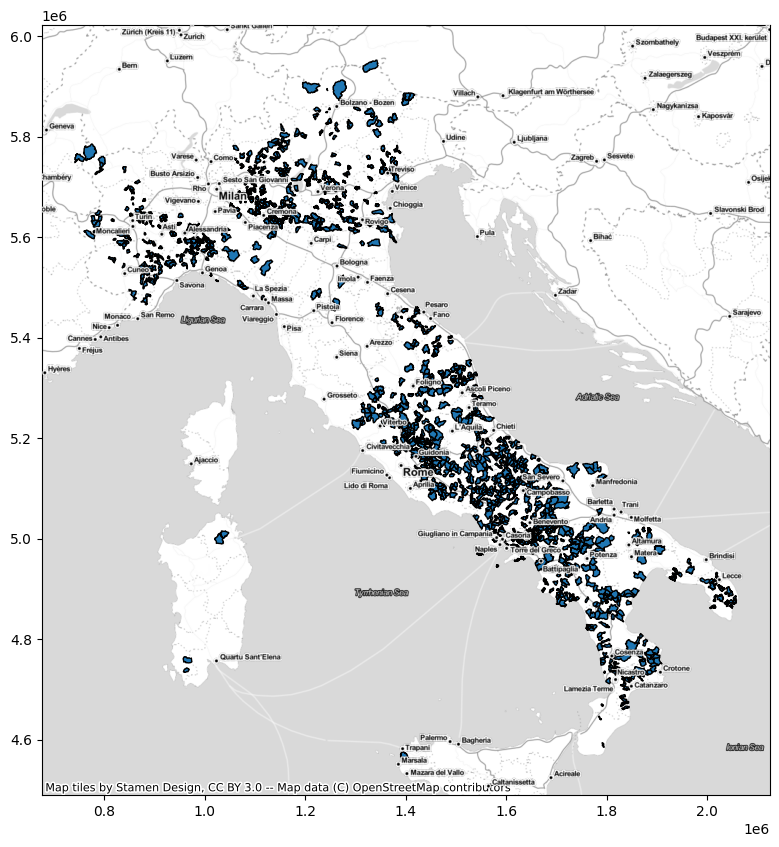

In [24]:
show_map(without_townhall_gdf)
#without_townhall_gdf.explore()

### Calculate statistics for each province

In [25]:
province_municipality_df = province_gdf[["id","geometry"]].sjoin(
        municipality_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_municipalities"] = province_municipality_df.groupby(province_municipality_df.index).count()["index_mun"]

In [26]:
province_without_townhall_df = province_gdf[["id","geometry"]].sjoin(
        without_townhall_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_without_townhall"] = province_without_townhall_df.groupby(province_without_townhall_df.index).count()["index_mun"]

<AxesSubplot: >

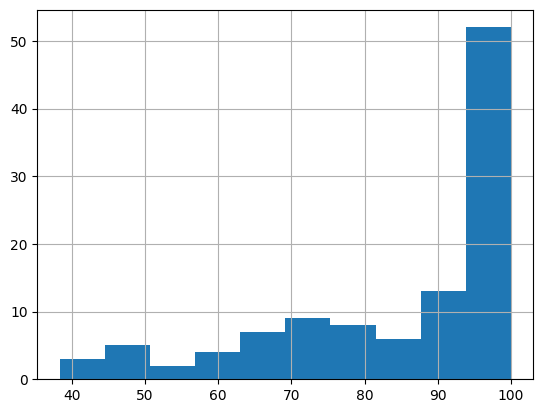

In [27]:
province_gdf["osm_availability"] = 100 * (1 - (province_gdf["num_without_townhall"] / province_gdf["num_municipalities"]))
province_gdf["osm_availability"].hist()

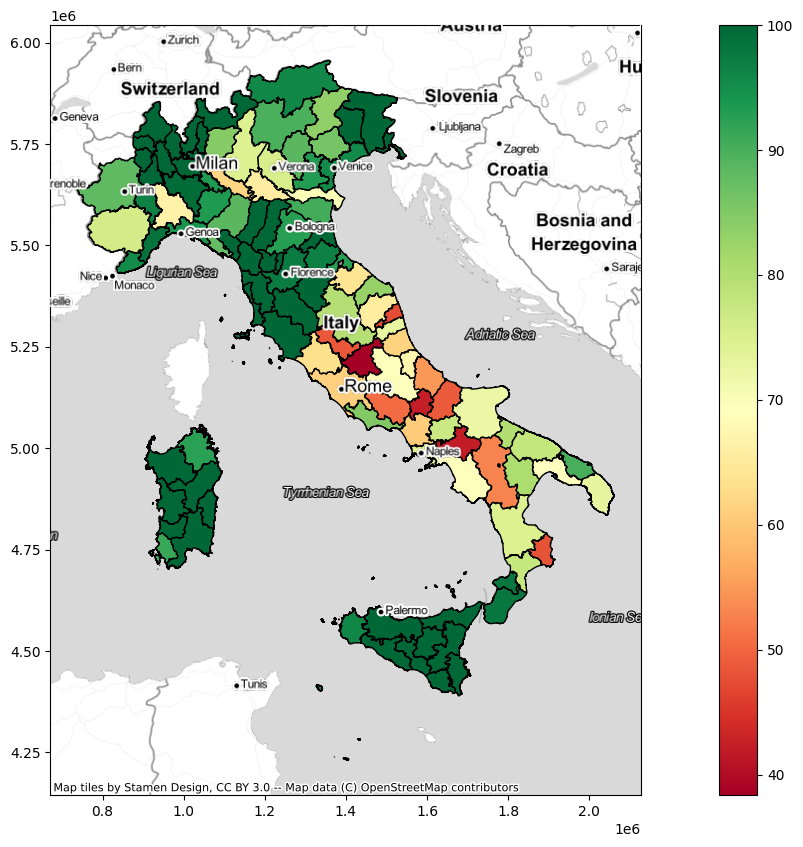

In [28]:
show_map(province_gdf, None, "osm_availability", "RdYlGn")

### Find OSM untagged building named as town halls

In [29]:
UNTAGGED_OVERPASS_QUERY=f"""
[out:json][timeout:300];
area({search_area_id})->.searchArea;
nwr["building"]["amenity"!="townhall"]["name"~"^(\s|palazzo|del|nuovo|comune|-)*municipio",i](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""
untagged_gdf = readOrFetchOverpassGeoDataFrame(untagged_json_file_path, UNTAGGED_OVERPASS_QUERY)
untagged_gdf.count()

id          30
osm_id      30
osm_type    30
osm_url     30
name        30
geometry    30
dtype: int64

In [30]:
untagged_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,277834707,way,https://www.openstreetmap.org/way/277834707,Municipio di Monserrato,"LINESTRING (9.14363 39.25416, 9.14336 39.25394..."
1,2,933053288,way,https://www.openstreetmap.org/way/933053288,Municipio,"LINESTRING (13.09184 37.95253, 13.09212 37.952..."
2,3,332108931,way,https://www.openstreetmap.org/way/332108931,Municipio Roma V - Aula consigliare,"LINESTRING (12.54262 41.88052, 12.54278 41.880..."
3,4,60145522,way,https://www.openstreetmap.org/way/60145522,Municipio,"LINESTRING (12.95500 41.58178, 12.95523 41.581..."
4,5,42089778,way,https://www.openstreetmap.org/way/42089778,Municipio Frosinone,"LINESTRING (13.35066 41.63963, 13.35074 41.639..."


In [31]:
untagged_missing_gdf = untagged_gdf.sjoin(
        without_townhall_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
untagged_missing_gdf.count()

id_hall          1
osm_id_hall      1
osm_type_hall    1
osm_url_hall     1
name_hall        1
geometry         1
index_town       1
id_town          1
osm_id_town      1
osm_type_town    1
osm_url_town     1
name_town        1
dtype: int64

In [32]:
untagged_missing_gdf.head()

,id_hall,osm_id_hall,osm_type_hall,osm_url_hall,name_hall,geometry,index_town,id_town,osm_id_town,osm_type_town,osm_url_town,name_town
10,11,672589063,way,https://www.openstreetmap.org/way/672589063,Municipio di Atella di Napoli (1928-46),"LINESTRING (14.26055 40.96097, 14.26056 40.961...",1834,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino


In [33]:
untagged_missing_gdf.to_file(untagged_missing_json_file_path, driver='GeoJSON')

In [34]:
#show_map(untagged_missing_gdf)
untagged_missing_gdf.explore()

## Step 2: Obtain the data from DBSN

Download the data from IGM DBSN ( https://www.igmi.org/it/dbsn-database-di-sintesi-nazionale ).

Then extract the catageory of elements you are interested in and save it as GeoJSON with EPSG 4326 SRID.
To accomplish you can use the script "filtra_dbsn.sh" in the project repository root (or https://www.dsantini.it/dbsn/filtra_dbsn.sh ).
The file downloaded below from dbsn_url has been generated with this script. 

## Step 3: Analyse useful data from DBSN

### Find possible town halls from DBSN

#### Download DBSN data on town halls

In [35]:
def download_file_if_not_exists(file_path, url):
    if not exists(file_path):
        try: 
            urlretrieve(url, file_path)
        except HTTPError as err:
            print("Failed downloading data from Overpass, retry later")
            raise err

In [36]:
# https://www.dsantini.it/dbsn/
dbsn_url = "https://www.dsantini.it/dbsn/notebooks/municipi.geojson"
download_file_if_not_exists(dbsn_json_file_path, dbsn_url)

In [37]:
dbsn_gdf = read_file(dbsn_json_file_path)
dbsn_gdf.count()


edifc_uso       3552
edifc_ty        3552
edifc_sot       3552
classid         3538
edifc_nome      3551
edifc_stat      3552
edifc_at        3505
scril           3499
meta_ist        3550
edifc_mon       3552
shape_Length    3552
shape_Area      3552
geometry        3552
dtype: int64

In [38]:
dbsn_gdf.head()

,edifc_uso,edifc_ty,edifc_sot,classid,edifc_nome,edifc_stat,edifc_at,scril,meta_ist,edifc_mon,shape_Length,shape_Area,geometry
0,0201,93,93,65D8ED81-5047-4CEA-9103-AA2034B665DD,Municipio di Lampedusa e Linosa,91,-9999.0,10k,04,02,66.022667,272.435503,"MULTIPOLYGON Z (((12.60941 35.50254 0.00000, 1..."
1,0201,93,93,D659C260-EDD5-4540-BC6C-EACB33EC447B,Municipio di Licata,91,-9999.0,10k,04,02,99.677476,358.678321,"MULTIPOLYGON Z (((13.93720 37.10145 0.00000, 1..."
2,0201,93,93,b4949764-f626-442c-89ad-200e56ea653d,Municipio di Cammarata,91,-9999.0,10k,04,02,133.927947,670.469227,"MULTIPOLYGON Z (((13.63779 37.63324 0.00000, 1..."
3,0201,93,93,ece5bd6f-834b-4230-a100-89232be50ff0,Municipio di San Biagio Platani,91,-9999.0,10k,04,02,134.259563,628.250694,"MULTIPOLYGON Z (((13.52434 37.50919 0.00000, 1..."
4,0201,93,93,7c14edd9-e910-4de2-9cb9-2cc44be6a4fc,Municipio di Cianciana,91,-9999.0,10k,04,02,126.859157,633.197564,"MULTIPOLYGON Z (((13.43422 37.51843 0.00000, 1..."


#### Province statistics of Public Data

In [39]:
province_dbsn_df = province_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_with_dbsn_townhall"] = province_dbsn_df.groupby(province_dbsn_df.index).count()["index_mun"]

<AxesSubplot: >

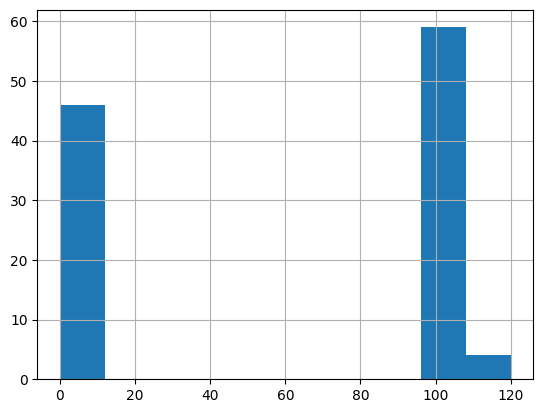

In [40]:
province_gdf["dbsn_availability"] = 100 * (province_gdf["num_with_dbsn_townhall"] / province_gdf["num_municipalities"])
province_gdf["dbsn_availability"].hist()

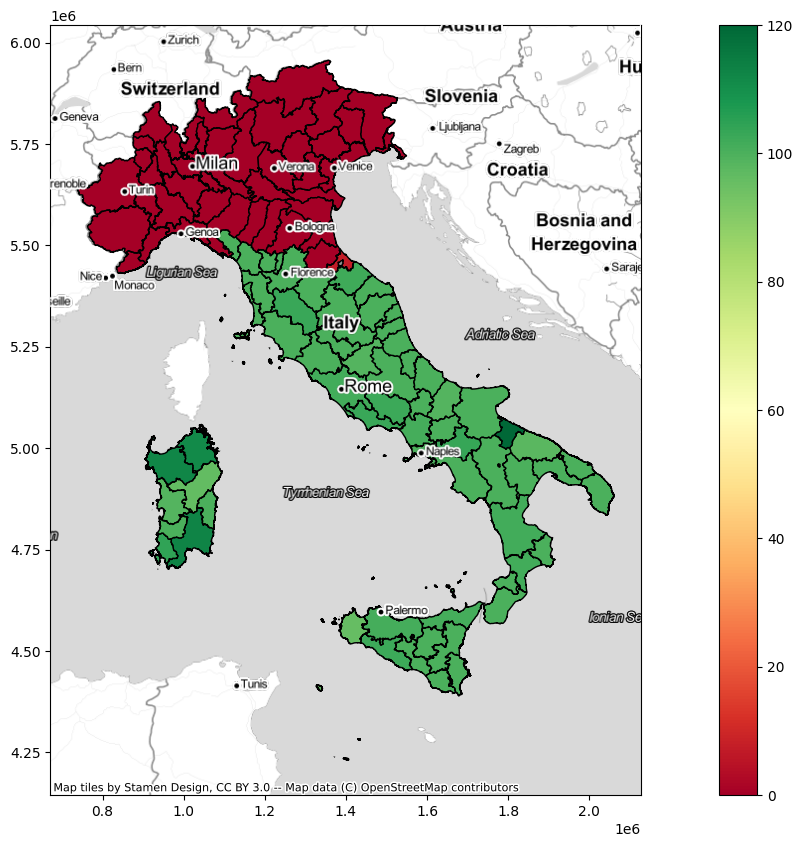

In [41]:
show_map(province_gdf, None, "dbsn_availability", "RdYlGn")

#### Compare existing town halls from OSM and Public Data

In [42]:
dbsn_existing_df = dbsn_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="dbsn",
        rsuffix="town"
    )
dbsn_existing_df.count()

edifc_uso       3557
edifc_ty        3557
edifc_sot       3557
classid         3543
edifc_nome      3556
edifc_stat      3557
edifc_at        3510
scril           3504
meta_ist        3555
edifc_mon       3557
shape_Length    3557
shape_Area      3557
geometry        3557
index_town      3557
id              3557
osm_id          3557
osm_type        3557
osm_url         3557
name            3557
dtype: int64

In [43]:
compare_gdf = merge(
    dbsn_existing_df,
    with_townhall_gdf,
    how="inner",
    left_on="index_town",
    right_on="index_town"
)
compare_gdf.count()

edifc_uso        2972
edifc_ty         2972
edifc_sot        2972
classid          2963
edifc_nome       2971
edifc_stat       2972
edifc_at         2939
scril            2933
meta_ist         2967
edifc_mon        2972
shape_Length     2972
shape_Area       2972
geometry_x       2972
index_town       2972
id               2972
osm_id           2972
osm_type         2972
osm_url          2972
name             2972
id_hall          2972
osm_id_hall      2972
osm_type_hall    2972
osm_url_hall     2972
name_hall        2395
geometry_y       2972
id_town          2972
osm_id_town      2972
osm_type_town    2972
osm_url_town     2972
name_town        2972
dtype: int64

In [44]:
compare_gdf["distance"] = compare_gdf["geometry_x"].to_crs(epsg=3857).distance(
    compare_gdf["geometry_y"].to_crs(epsg=3857)
  )
compare_gdf["geometry"] = compare_gdf.apply(
    lambda row: LineString([row['geometry_x'].centroid, row['geometry_y'].centroid]),
    axis=1
  ).set_crs(epsg=4326)

/home/daniele/.miniconda3/envs/osm/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


array([[<AxesSubplot: title={'center': 'distance'}>]], dtype=object)

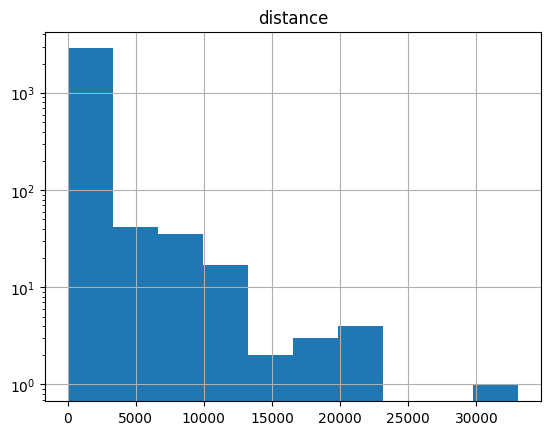

In [45]:
compare_gdf.hist(log=True, column="distance")

In [46]:
conflict_mask=compare_gdf["distance"] > 1000
for word in [
        "delegazione",
        "circoscrizione",
        "quartiere",
        "frazione",
        "municipalità",
        "municipio roma",
        "consorzio",
        "2° municipio",
        "distaccat"
    ]:
    conflict_mask &= ~(compare_gdf["name_hall"].str.lower().str.contains(word, na=False))
conflict_mask.value_counts()

False    2845
True      127
Name: distance, dtype: int64

In [54]:
dbsn_conflict_gdf = compare_gdf[conflict_mask]
dbsn_conflict_gdf["name_hall"].dropna().drop_duplicates()

189     Comune dell'Aquila Ricostruzione Beni Pubblici
191               Comune dell'Aquila Equità tributaria
193           Comune dell'Aquila Ricostruzione Privata
194           Comune dell'Aquila Recostruzione Privata
195                     Consiglio Comunale dell'Aquila
                             ...                      
2600                                 Comune di Sassari
2601                                            comune
2649                               Municipio di Ozieri
2786                             Municipio di Massafra
2799                            Ufficio tributi locali
Name: name_hall, Length: 71, dtype: object

In [48]:
dbsn_conflict_gdf.explore()

In [49]:
dbsn_conflict_gdf.drop(["geometry_x", "geometry_y"], axis=1).to_file(dbsn_conflict_file_path, driver="GeoJSON")

#### Getting missing town halls from Public Data

In [50]:
dbsn_missing_df = dbsn_gdf.sjoin(
    without_townhall_gdf,
    how="inner",
    predicate="within"
)
dbsn_missing_df.count()

edifc_uso       849
edifc_ty        849
edifc_sot       849
classid         844
edifc_nome      849
edifc_stat      849
edifc_at        832
scril           832
meta_ist        848
edifc_mon       849
shape_Length    849
shape_Area      849
geometry        849
index_right     849
id              849
osm_id          849
osm_type        849
osm_url         849
name            849
dtype: int64

In [51]:
dbsn_missing_df.head()

,edifc_uso,edifc_ty,edifc_sot,classid,edifc_nome,edifc_stat,edifc_at,scril,meta_ist,edifc_mon,shape_Length,shape_Area,geometry,index_right,id,osm_id,osm_type,osm_url,name
51,0201,01,01,ccebcf60-070d-4e16-a5b5-ddaae2aebab3,Municipio di Castelbellino,03,-29999.0,10k,04,02,112.731642,498.948045,"MULTIPOLYGON Z (((13.14609 43.48797 0.00000, 1...",6471,6472,42476,relation,https://www.openstreetmap.org/relation/42476,Castelbellino
52,0201,01,01,c33b9af6-8977-4c18-b181-6da6f1d4ad4c,Municipio di San Paolo di Jesi,03,-29999.0,10k,04,02,133.693143,783.324298,"MULTIPOLYGON Z (((13.17384 43.45493 0.00000, 1...",6458,6459,42462,relation,https://www.openstreetmap.org/relation/42462,San Paolo di Jesi
61,0201,01,01,E0577A0C-BD70-473B-B93E-2CD1EC108339,Municipio di Cupramontana,03,-9999.0,10k,05,02,110.947122,502.926217,"MULTIPOLYGON Z (((13.11578 43.44564 0.00000, 1...",6448,6449,42451,relation,https://www.openstreetmap.org/relation/42451,Cupramontana
64,0201,01,01,4bd670b4-e7de-4c0d-8412-e504b335a90b,Municipio di Poggio San Marcello,03,-29999.0,10k,04,02,61.302157,230.025172,"MULTIPOLYGON Z (((13.07699 43.51150 0.00000, 1...",6468,6469,49127,relation,https://www.openstreetmap.org/relation/49127,Poggio San Marcello
78,0201,01,01,b065057b-7b88-4dd0-afd0-82bfddbc2314,Municipio di Belvedere Ostrense,03,-29999.0,10k,04,02,80.870315,321.332155,"MULTIPOLYGON Z (((13.16665 43.58040 0.00000, 1...",6462,6463,42496,relation,https://www.openstreetmap.org/relation/42496,Belvedere Ostrense


In [52]:
dbsn_missing_df.to_file(dbsn_missing_file_path, driver="GeoJSON")

In [53]:
#%pip install folium matplotlib mapclassify
dbsn_missing_df.explore()